<a href="https://colab.research.google.com/github/giovadg/physnum_CUDA/blob/main/MonteCarlo/Exercise_montecarlo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h -nv -O ach.h
!wget https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp -nv -O nvtx3.hpp
!wget https://github.com/giovadg/physnum_CUDA/tree/main/MonteCarlo/input -nv -O input
!wget https://github.com/giovadg/physnum_CUDA/tree/main/MonteCarlo/ConfigFile.h -nv -O ConfigFile.h
!wget https://github.com/giovadg/physnum_CUDA/tree/main/MonteCarlo/ConfigFile.hpp -nv -O ConfigFile.hpp

2025-12-02 11:33:53 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/ach.h [5329/5329] -> "ach.h" [1]
2025-12-02 11:33:53 URL:https://raw.githubusercontent.com/NVIDIA/accelerated-computing-hub/refs/heads/main/tutorials/cuda-cpp/notebooks/02.02-Asynchrony/Sources/nvtx3.hpp [105839/105839] -> "nvtx3.hpp" [1]
2025-12-02 11:33:54 URL:https://github.com/giovadg/physnum_CUDA/blob/main/MonteCarlo/input [186036] -> "input" [1]
2025-12-02 11:33:55 URL:https://github.com/giovadg/physnum_CUDA/blob/main/MonteCarlo/ConfigFile.h [192434] -> "ConfigFile.h" [1]
2025-12-02 11:33:56 URL:https://github.com/giovadg/physnum_CUDA/blob/main/MonteCarlo/ConfigFile.hpp [200656] -> "ConfigFile.hpp" [1]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi --query-gpu=name,compute_cap --format=csv

name, compute_cap
Tesla T4, 7.5


In [ ]:
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub > /dev/null 2>&1
!sudo add-apt-repository -y "deb https://developer.download.nvidia.com/devtools/repos/ubuntu$(source /etc/lsb-release; echo "$DISTRIB_RELEASE" | tr -d .)/$(dpkg --print-architecture)/ /" > /dev/null 2>&1
!sudo apt install -y nsight-systems > /dev/null 2>&1
!sudo apt update -qq
!sudo apt install -y nsight-systems-

57 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
W: https://developer.download.nvidia.com/devtools/repos/ubuntu2204/amd64/Release.gpg: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages were automatically installed and are no longer required:
  libxcb-cursor0 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxcomposite1 libxkbcommon-x11-0 libxtst6 nsight-systems-2025.6.1
Use 'sudo apt autoremove' to remove them.
The following packages will be REMOVED:
  nsight-systems
0 upgraded, 0 newly installed, 1 to remove and 

In [ ]:
%%writefile test.cpp

#include <iostream>
#include <vector>
#include <fstream>
#include <cmath>
#include <numeric>
#include <cstdlib>
#include "ach.h"
#include <curand_kernel.h>

#include <thrust/transform.h>
#include <thrust/tabulate.h>
#include <thrust/universal_vector.h>
#include <thrust/iterator/counting_iterator.h>
#include <thrust/iterator/transform_iterator.h>
#include <thrust/reduce.h>
#include <thrust/sort.h>
#include <thrust/copy.h>
#include <thrust/for_each.h>
#include <thrust/fill.h>
#include <thrust/generate.h>
#include <string.h>
#include "ConfigFile.h"
#include <algorithm>
#include <chrono>
#include <boost/random.hpp>
#include "nvtx3.hpp"
#include <cub/cub.cuh>
using namespace std;



using namespace std;

__global__ void cuda_moments(double* mom_ptr, const double* v_ptr, int N_part)
{
    int ip = blockIdx.x * blockDim.x + threadIdx.x;
    if (ip >= N_part) return;

    double v = v_ptr[ip];

    atomicAdd(&mom_ptr[0], v);
    atomicAdd(&mom_ptr[1], v*v);
}


  __global__ void binning_fun_cuda(double* bins_ptr, const double* v_ptr, int N_part, int N_bins, double h, double vlb){
    int ip = blockIdx.x * blockDim.x + threadIdx.x;
    if (ip >= N_part) return;
    int index = int((v_ptr[ip] - vlb)/h);
    if( index >= 0 && index < N_bins ){
      atomicAdd(&bins_ptr[index], 1);
    }
  }

__global__ void time_step_cuda(double* v_ptr, int N_part,
                    double gamma, double vc, double prefactor, double dt){
  int i = blockIdx.x * blockDim.x + threadIdx.x;
  if (i >= N_part) return;
  unsigned long seed = clock64();   // GPU clock
  curandState state;
  curand_init(seed, i, 0, &state);

  double acc =  -gamma * (v_ptr[i] - vc);
  double z = curand_normal(&state);  // N(0,1)
  v_ptr[i] = v_ptr[i] + dt*acc + prefactor * z;

  }

__global__ void generate_normals(double* v_ptr, int N_part, unsigned long seed, double mean, double stddev) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i >= N_part) return;
    curandState state;
    curand_init(seed, i, 0, &state);
    double z = curand_normal(&state);  // N(0,1)
    v_ptr[i] = mean + stddev * z;      // N(mean, stddev^2)
}

struct Selector {
    int N_part;
    double vg_D, vd_D;
    __device__ __host__ double operator()(int ip) const {
        return (ip < N_part/2) ? vg_D : vd_D;
    }
};


class Exercice7
{

private:
  // definition des constantes
  const double pi=3.1415926535897932384626433832795028841971e0;
  // definition des variables
  double tfin, dt, t;          // Temps final
  unsigned int nsteps;  // Nombre de pas de temps
  double D;        // Coefficient de diffusion
  double v0;       // Moyenne de la Gaussienne initiale
  double gamma;    // Coefficient de friction
  double vc;       // Vitesse critique pour la friction
  int    N_part;   // Nombre de particules numériques
  int    N_bins;   // Nombre de bins de l'histogramme
  double h;        // Pas de l'histogramme

  thrust::universal_vector<double> v ;
  vector<double> bins ;

  double vlb;      // v_min des bins de l'histogramme
  double vd_D;     // pour la distribution uniforme entre [vg_D et vd_D]
                   // ou double Dirac f = 1/2 (\delta(v-vg_D) + \delta(v-vd_D))
  double vg_D;     // pour la distribution uniforme entre [vg_D et vd_D]
                   // ou double Dirac f = 1/2 (\delta(v-vg_D) + \delta(v-vd_D))
  string initial_distrib; // type de distribution initiale ('D' pour Dirac)
  double vhb;      // v_max pour les bins de l'histogramme
  double sigma0;   // écart-type de la Gaussienne initiale
  double prefactor; // \sqrt{2 D \Delta t}
  unsigned int sampling;  // Nombre de pas de temps entre chaque ecriture des diagnostics
  unsigned int last;       // Nombre de pas de temps depuis la derniere ecriture des diagnostics
  ofstream outputFile;
  string output;
  double* v_ptr;
  double* mom_ptr;
  double* bins_ptr;

  thrust::device_vector<double> bins_device;
  thrust::device_vector<double> moments_device;
  int blocksize;
  int gridsize;
  std::vector<double> moments = std::vector<double>(2);

  void printOut(bool write)
  {
    double var;
    if((!write && last>=sampling) || (write && last!=1))
    {
        building_outputs();
        var = moments[1] - moments[0]*moments[0];

      {
        nvtx3::scoped_range r_save{"save on disk"};
        outputFile << t << " " << N_part<< " "<<moments[0]<<" "<<var;
        for(int ib = 0; ib < N_bins; ++ib){
          outputFile<<" "<< bins[ib];
        }
        outputFile <<endl; // write output on file
        last = 1;
      }
    }
    else
    {
      last++;
    }
  }


  double acceleration(double v_p){
    return -gamma*(v_p - vc);
  }

  // here the initialization function is defined
  void initialisation(){
    if (initial_distrib == "D"){
        cout << "Delta distribution"<<endl;
        thrust::tabulate(thrust::device, v.begin(), v.end(),
                 Selector{N_part, vg_D, vd_D});
     }
     else{
        cout << "Gaussian distribution with CUDA"<<endl;
        generate_normals<<<gridsize, blocksize>>>(v_ptr, N_part, 100, v0, sigma0);
     }
     return;
   }
    //----------------------end of initialization --------------


  void building_outputs(){
      nvtx3::scoped_range r_moments{"building moments and filling bins"};
      thrust::fill(moments_device.begin(), moments_device.end(), 0.0);
      thrust::fill(bins_device.begin(), bins_device.end(), 0.0);

      cuda_moments<<<gridsize, blocksize>>>(mom_ptr, v_ptr,N_part);
      binning_fun_cuda<<<gridsize,blocksize>>>(bins_ptr, v_ptr, N_part, N_bins, h, vlb);

      cudaDeviceSynchronize();
      thrust::copy(moments_device.begin(), moments_device.end(), moments.begin());
      thrust::copy(bins_device.begin(), bins_device.end(), bins.begin());
      moments[0] = moments[0]/N_part;
      moments[1] = moments[1]/N_part;
  }



public:

  Exercice7(int argc, char* argv[])
  {
    string inputPath("configuration.in"); // Fichier d'input par defaut
    if(argc>1) // Fichier d'input specifie par l'utilisateur ("./Exercice7 config_perso.in")
      inputPath = argv[1];

    ConfigFile configFile(inputPath); // Les parametres sont lus et stockes dans une "map" de strings.
    for(int i(2); i<argc; ++i) // Input complementaires ("./Exercice3 config_perso.in input_scan=[valeur]")
      configFile.process(argv[i]);

    tfin     = configFile.get<double>("tfin",10);
    nsteps   = configFile.get<unsigned int>("nsteps",100);
    D        = configFile.get<double>("D",0.1);
    gamma    = configFile.get<double>("gamma",0.08);
    v0       = configFile.get<double>("v0",v0);
    sigma0   = configFile.get<double>("sigma0",1);
    N_part   = configFile.get<double>("N_part",10000);
    N_bins   = configFile.get<double>("N_bins",30);
    vhb      = configFile.get<double>("vhb",5);
    vlb      = configFile.get<double>("vlb",-5);
    vd_D     = configFile.get<double>("vd_D",2);
    vg_D     = configFile.get<double>("vg_D",-2);
    vc       = configFile.get<double>("vc",0);
    sampling = configFile.get<unsigned int>("sampling",2);
    initial_distrib = configFile.get<string>("initial_distrib","G");
    output = configFile.get<string>("output","output.out");

    dt        = tfin / nsteps;
    prefactor = sqrt(2.*D*dt);
    h         = (vhb - vlb)/N_bins;

    v.resize(N_part);
    moments_device.resize(2);
    bins_device.resize(N_bins);
    bins.resize(N_bins);

    v_ptr = thrust::raw_pointer_cast(v.data());
    mom_ptr=thrust::raw_pointer_cast(moments_device.data());
    bins_ptr=thrust::raw_pointer_cast(bins_device.data());

    blocksize = 256;
    gridsize = (N_part + blocksize*2 - 1) / blocksize;

    outputFile.open(output);
    outputFile.precision(15);

  };

    ~Exercice7()
    {
        if (outputFile.is_open())
            outputFile.close();
    }


  void run()
  {
    t    = 0.; // initialiser le temps
    last = 0; // initialise le parametre d'ecriture
    initialisation();
    cudaDeviceSynchronize();
    printOut(true); // ecrire premier pas de temps

    int blockSize = 256;
    int gridSize = (N_part + blockSize*2 - 1) / blockSize;
    for(unsigned int i(0); i<nsteps; ++i) // boucle sur les pas de temps
    {
      {
        nvtx3::scoped_range r_compute{"time step SDE"};
        time_step_cuda<<<gridSize, blockSize>>>(v_ptr,  N_part, gamma, vc, prefactor, dt);
        cudaDeviceSynchronize();
      }
        t = t + dt;
        printOut(false); // ecrire pas de temps actuel
    }
    printOut(true); // ecrire dernier pas de temps
  };
};


int main(int argc, char* argv[])
{
  Exercice7 engine(argc,argv); // definer la class pour la simulation
  auto start = std::chrono::high_resolution_clock::now();
  engine.run(); // executer la simulation
  auto end  = std::chrono::high_resolution_clock::now();
  auto diff = std::chrono::duration<double>(end-start).count();
  printf("The duration of the simulation is %g [s] \n", diff);
  cout << "Fin de la simulation." << endl;
  return 0;
}

Overwriting test.cpp


In [ ]:
#!nvcc  test.cpp -o b.out
# !nvcc -x cu test.cpp -o --extended-lambda <b.out
!nvcc -o /tmp/b_gpu.out --extended-lambda test.cpp -x cu -arch=native # build executable

In [ ]:
!nsys profile --cuda-event-trace=false --force-overwrite true -o test /tmp/b_gpu.out input # run and profile executable


	tfin=60
	nsteps=100
	D=0.1
	gamma=0.08
	v0=-2.5
	sigma0=0.3
	N_part=1e+06
	N_bins=100
	vhb=5
	vlb=-5
	vd_D=4
	vg_D=-4
	vc=1.7
	sampling=20
	initial_distrib=G
	output=output.out
Gaussian distribution with CUDA
The duration of the simulation is 1.88881 [s] 
Fin de la simulation.
Generating '/tmp/nsys-report-136c.qdstrm'
[1/1] [========================100%] test.nsys-rep
Generated:
	/content/test.nsys-rep


In [ ]:
!/tmp/b_gpu.out input

	tfin=60
	nsteps=100
	D=0.1
	gamma=0.08
	v0=-2.5
	sigma0=0.3
	N_part=1e+06
	N_bins=100
	vhb=5
	vlb=-5
	vd_D=4
	vg_D=-4
	vc=1.7
	sampling=20
	initial_distrib=G
	output=output.out
Gaussian distribution with CUDA
The duration of the simulation is 1.90354 [s] 
Fin de la simulation.


1000000.0


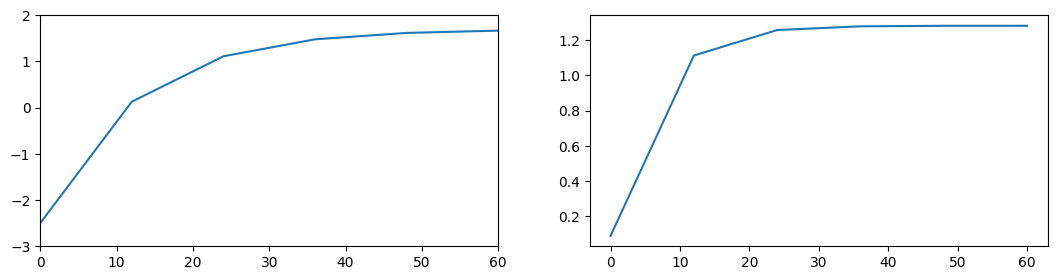

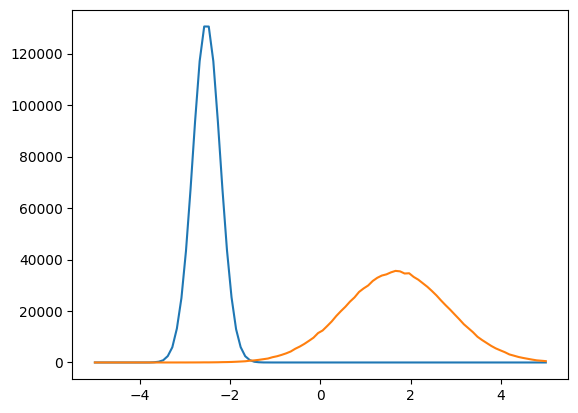

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt('output.out')

# data.shape
fig, ax = plt.subplots(ncols=2, figsize=(13, 3))
ax[0].plot(data[:, 0], data[:, 2])
ax[1].plot(data[:, 0], data[:, 3])
# ax[1].plot(data[:,10])
# print(data[:, 0], data[:, 2])
ax[0].set_ylim([-3,2])
ax[0].set_xlim([0,60])



plt.figure()
hist_ini = [_ for _ in data[0,4:]]
hist_fin = [_  for _ in data[-1,4:]]
bins = np.linspace(-5,5,len(hist_ini))
plt.plot(bins,hist_ini)
plt.plot(bins,hist_fin)
print(data[0,1])